In [4]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math

%load_ext autoreload
%autoreload 2

%matplotlib inline

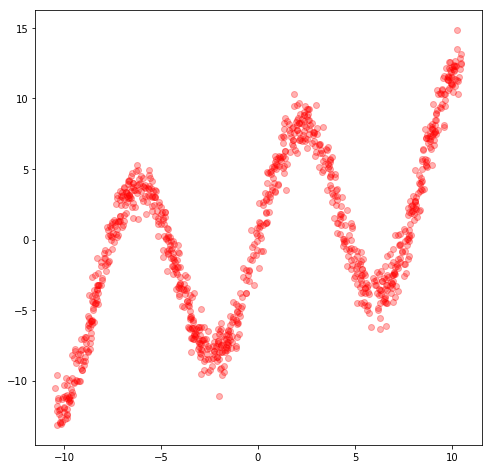

In [7]:
NSAMPLE = 1000
x_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_data = np.float32(np.random.normal(size=(NSAMPLE,1)))
y_data = np.float32(np.sin(0.75*x_data)*7.0+x_data*0.5+r_data*1.0)

plt.figure(figsize=(8, 8))
plot_out = plt.plot(x_data,y_data,'ro',alpha=0.3)
plt.show()

In [8]:
x = tf.placeholder(dtype=tf.float32, shape=[None,1])
y = tf.placeholder(dtype=tf.float32, shape=[None,1])

In [9]:
NHIDDEN = 20
W = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=1.0, dtype=tf.float32))
b = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=1.0, dtype=tf.float32))

W_out = tf.Variable(tf.random_normal([NHIDDEN,1], stddev=1.0, dtype=tf.float32))
b_out = tf.Variable(tf.random_normal([1,1], stddev=1.0, dtype=tf.float32))

hidden_layer = tf.nn.tanh(tf.matmul(x, W) + b)
y_out = tf.matmul(hidden_layer,W_out) + b_out

In [10]:
lossfunc = tf.nn.l2_loss(y_out-y);


In [11]:
train_op = tf.train.RMSPropOptimizer(learning_rate=0.1, decay=0.8).minimize(lossfunc)


In [14]:
try:
    sess.close()
except:
    "didn't close"
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [15]:
NEPOCH = 1000
for i in range(NEPOCH):
  sess.run(train_op,feed_dict={x: x_data, y: y_data})

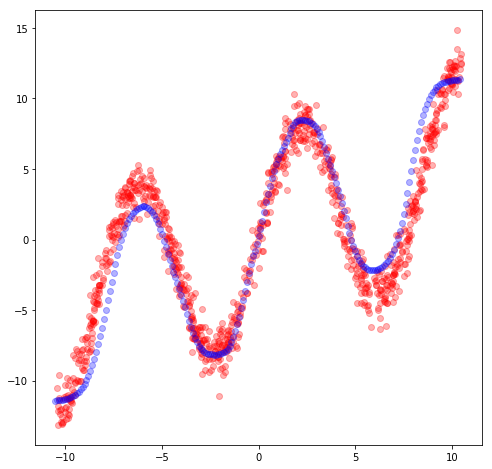

In [16]:
x_test = np.float32(np.arange(-10.5,10.5,0.1))
x_test = x_test.reshape(x_test.size,1)
y_test = sess.run(y_out,feed_dict={x: x_test})

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.3)
plt.show()

sess.close()

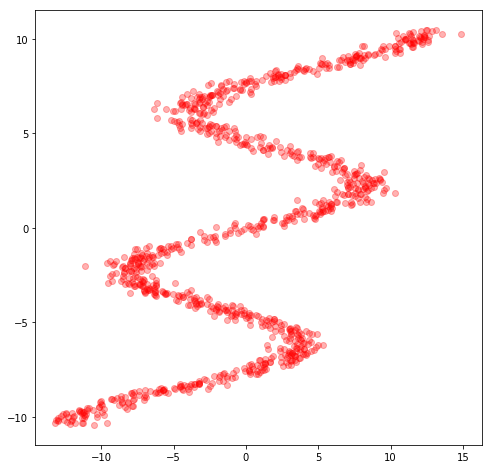

In [17]:
temp_data = x_data
x_data = y_data
y_data = temp_data

plt.figure(figsize=(8, 8))
plot_out = plt.plot(x_data,y_data,'ro',alpha=0.3)
plt.show()

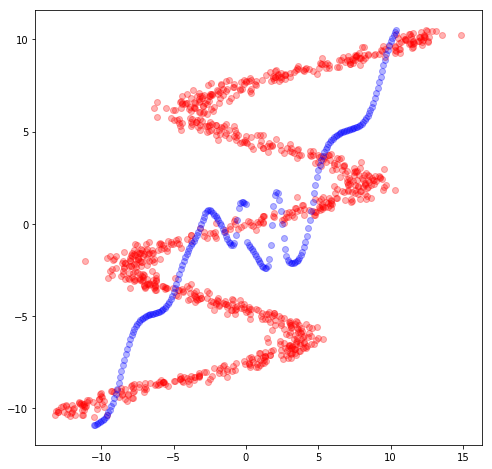

In [18]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

for i in range(NEPOCH):
  sess.run(train_op,feed_dict={x: x_data, y: y_data})

x_test = np.float32(np.arange(-10.5,10.5,0.1))
x_test = x_test.reshape(x_test.size,1)
y_test = sess.run(y_out,feed_dict={x: x_test})

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.3)
plt.show()

sess.close()

In [29]:
NHIDDEN = 24
STDEV = 0.5
KMIX = 24 # number of mixtures
NOUT = KMIX * 3 # pi, mu, stdev

x = tf.placeholder(dtype=tf.float32, shape=[None,1], name="x")
y = tf.placeholder(dtype=tf.float32, shape=[None,1], name="y")

Wh = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32))
bh = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32))

Wo = tf.Variable(tf.random_normal([NHIDDEN,NOUT], stddev=STDEV, dtype=tf.float32))
bo = tf.Variable(tf.random_normal([1,NOUT], stddev=STDEV, dtype=tf.float32))

hidden_layer = tf.nn.tanh(tf.matmul(x, Wh) + bh)
output = tf.matmul(hidden_layer,Wo) + bo

def get_mixture_coef(output):
    out_pi = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")
    out_sigma = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")
    out_mu = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")

    out_pi, out_sigma, out_mu = tf.split(output,3,1 )

    max_pi = tf.reduce_max(out_pi, 1, keepdims=True)
    out_pi = tf.subtract(out_pi, max_pi)

    out_pi = tf.exp(out_pi)

    normalize_pi = tf.linalg.inv(tf.reduce_sum(out_pi, 1, keepdims=True))
    out_pi = tf.multiply(normalize_pi, out_pi)

    out_sigma = tf.exp(out_sigma)

    return out_pi, out_sigma, out_mu

# 

In [30]:
out_pi, out_sigma, out_mu = get_mixture_coef(output)

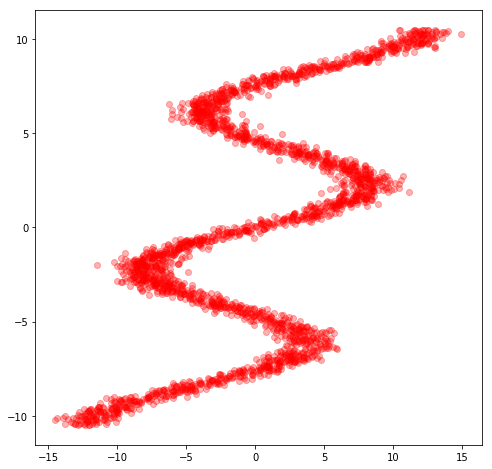

In [31]:
NSAMPLE = 2500

y_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_data = np.float32(np.random.normal(size=(NSAMPLE,1))) # random noise
x_data = np.float32(np.sin(0.75*y_data)*7.0+y_data*0.5+r_data*1.0)

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', alpha=0.3)
plt.show()

In [34]:
oneDivSqrtTwoPI = 1 / math.sqrt(2*math.pi) # normalisation factor for gaussian, not needed.
def tf_normal(y, mu, sigma):
    result = tf.subtract(y, mu)
    result = tf.multiply(result,tf.linalg.inv(sigma))
    result = -tf.square(result)/2
    return tf.multiply(tf.exp(result),tf.linalg.inv(sigma))*oneDivSqrtTwoPI

def get_lossfunc(out_pi, out_sigma, out_mu, y):
    result = tf_normal(y, out_mu, out_sigma)
    result = tf.multiply(result, out_pi)
    result = tf.reduce_sum(result, 1, keepdims=True)
    result = -tf.log(result)
    return tf.reduce_mean(result)

lossfunc = get_lossfunc(out_pi, out_sigma, out_mu, y)
train_op = tf.train.AdamOptimizer().minimize(lossfunc)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

NEPOCH = 10000
loss = np.zeros(NEPOCH) # store the training progress here.
for i in range(NEPOCH):
    sess.run(train_op,feed_dict={x: x_data, y: y_data})
    loss[i] = sess.run(lossfunc, feed_dict={x: x_data, y: y_data})


In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(100, NEPOCH,1), loss[100:], 'r-')
plt.show()